In this notebook we will learn how to create and train an embedding layer for the words appearing in a text data. We will then train a simple DNN based model to do sentiment analysis on this data. 

## Exercise

This is exercise 13.10 in [this](https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/) book.

### Problem Statement

In this exercise you will download a dataset, split it, create a tf.data.Dataset to load it and preprocess it efficiently, then build and train a binary classification model containing an Embedding layer:

  - a. Download the [Large Movie Review Dataset](http://ai.stanford.edu/~amaas/data/sentiment/), which contains 50,000 movies reviews from the Internet Movie Database. The data is organized in two directories, train and test, each containing a pos subdirectory with 12,500 positive reviews and a neg subdirectory with 12,500 negative reviews. Each review is stored in a separate text file. There are other files and folders (including preprocessed bag-of-words), but we will ignore them in this exercise.
  
    
  - b. Split the test set into a validation set (15,000) and a test set (10,000).
  
  
  - c. Use tf.data to create an efficient dataset for each set.
  
  
  - d. Create a binary classification model, using a TextVectorization layer to preprocess each review. If the TextVectorization layer is not yet available (or if you like a challenge), try to create your own custom preprocessing layer: you can use the functions in the tf.strings package, for example lower() to make everything lowercase, regex_replace() to replace punctuation with spaces, and split() to split words on spaces. You should use a lookup table to output word indices, which must be prepared in the adapt() method.
  
  
  - e. Add an Embedding layer and compute the mean embedding for each review, multiplied by the square root of the number of words (see Chapter 16). This rescaled mean embedding can then be passed to the rest of your model.
  
  
  - f. Train the model and see what accuracy you get. Try to optimize your pipelines to make training as fast as possible.


  - g. Use TFDS to load the same dataset more easily: tfds.load("imdb_reviews").

In [1]:
import tensorflow as tf
import tensorflow.keras as keras
print('tensorflow version: {}'.format(tf.__version__))
print('keras version: {}'.format(keras.__version__))

tensorflow version: 2.1.0
keras version: 2.2.4-tf


In [2]:
import os
print('cwd: {}'.format(os.getcwd()))

cwd: /home/prarit/MachineLearningProjects/Word-Embeddings


### Downloading the Large Movie Review Dataset

In [3]:
# good tutorial on using wget: https://www.tecmint.com/download-and-extract-tar-files-with-one-command/
# turn off verbose output of wget using the flag -nv : https://shapeshed.com/unix-wget/#how-to-turn-off-verbose-output 
!wget -c -nv http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz -o - 

In [4]:
# uncompress the downloaded files
!tar xzf aclImdb_v1.tar.gz

Note that tensorflow also provides this dataset: https://www.tensorflow.org/api_docs/python/tf/keras/datasets/imdb

### Briefly Explore the Dataset

In [5]:
# list the files in the current working directory
os.listdir()

['README.md',
 '.gitignore',
 'log_dir',
 '.ipynb_checkpoints',
 '.git',
 'aclImdb',
 'Word-Embeddings.ipynb',
 'aclImdb_v1.tar.gz']

We see that aclImdb_v1.tar.gz was extracted to a folder called aclImdb. Let's see the contents of this file.

In [6]:
path = os.path.join(os.getcwd() , 'aclImdb')
contents = os.listdir(path)
print('The contents of aclImdb are: \n{}'.format(contents))

The contents of aclImdb are: 
['imdb.vocab', 'train', 'README', 'imdbEr.txt', 'test']


There is a README file in aclImdb, let us read it.

In [7]:
# read README
filepath = os.path.join(path, 'README')
with open(filepath, 'r') as f:
    print(f.read())

Large Movie Review Dataset v1.0

Overview

This dataset contains movie reviews along with their associated binary
sentiment polarity labels. It is intended to serve as a benchmark for
sentiment classification. This document outlines how the dataset was
gathered, and how to use the files provided. 

Dataset 

The core dataset contains 50,000 reviews split evenly into 25k train
and 25k test sets. The overall distribution of labels is balanced (25k
pos and 25k neg). We also include an additional 50,000 unlabeled
documents for unsupervised learning. 

In the entire collection, no more than 30 reviews are allowed for any
given movie because reviews for the same movie tend to have correlated
ratings. Further, the train and test sets contain a disjoint set of
movies, so no significant performance is obtained by memorizing
movie-unique terms and their associated with observed labels.  In the
labeled train/test sets, a negative review has a score <= 4 out of 10,
and a positive review has a scor

From README, we find that the train/test folder contains a 'pos' folder for positive reviews and a 'neg' for negative reviews along with .txt files containing urls of positive and negative reviews respectively. There are also some other files for bag-of-words features etc. 

Each train/test folder contains a total of 25000 reviews of which 12500 are positive reviews and 12500 are negative reviews.

Let's verify the above about the 'train' folder

In [8]:
train_path = os.path.join(path,'train')
print('contents of the train folder: \n{}'.format(os.listdir(train_path)))

contents of the train folder: 
['unsup', 'urls_pos.txt', 'pos', 'labeledBow.feat', 'unsupBow.feat', 'neg', 'urls_neg.txt', 'urls_unsup.txt']


In order to create a dataset, we need the path to all the reviews. We can create the corresponding list of paths using glob

In [9]:
import glob

In [10]:
# paths to the positive reviews in the training set
train_pos_path = os.path.join(train_path, 'pos', '*.txt')
train_pos_reviews = glob.glob(train_pos_path)
print('No. of train-set files with positive reviews: {}'.format(len(train_pos_reviews)))

No. of train-set files with positive reviews: 12500


In [11]:
# paths to the negative reviews in the training set
train_neg_path = os.path.join(train_path, 'neg', '*.txt')
train_neg_reviews = glob.glob(train_neg_path)
print('No. of train-set files with negative reviews: {}'.format(len(train_neg_reviews)))

No. of train-set files with negative reviews: 12500


let us give a brief look at a positive review. 

In [12]:
file = train_pos_reviews[0]
with open(file, 'r') as f:
    print(f.read())

I watch them all.<br /><br />It's not better than the amazing ones (_Strictly Ballroom_, _Shall we dance?_ (Japanese version), but it's completely respectable and pleasingly different in parts.<br /><br />I am an English teacher and I find some of the ignorance about language in some of these reviews rather upsetting. For example: the "name should scream don't watch. 'How she move.' Since when can movie titles ignore grammar?" <br /><br />There is nothing inherently incorrect about Caribbean English grammar. It's just not Canadian standard English grammar. Comments about the dialogue seem off to me. I put on the subtitles because I'm a Canadian standard English speaker, so I just AUTOMATICALLY assumed that I would have trouble understanding all of it. It wasn't all that difficult and it gave a distinctly different flavour as the other step movies I have seen were so American.<br /><br />I loved that this movie was set in Toronto and, in fact, wish it was even more clearly set there. I 

Later, we will like to load an preprocess all the data using tensorflow's data API, therefore let us quickly see how to read the same file as above but this time by using tensorflow's [TextLineDataset](https://www.tensorflow.org/api_docs/python/tf/data/TextLineDataset) method.

In [13]:
pos_fl0 = tf.data.TextLineDataset(file)
for item in pos_fl0:
    print(item)

tf.Tensor(b'I watch them all.<br /><br />It\'s not better than the amazing ones (_Strictly Ballroom_, _Shall we dance?_ (Japanese version), but it\'s completely respectable and pleasingly different in parts.<br /><br />I am an English teacher and I find some of the ignorance about language in some of these reviews rather upsetting. For example: the "name should scream don\'t watch. \'How she move.\' Since when can movie titles ignore grammar?" <br /><br />There is nothing inherently incorrect about Caribbean English grammar. It\'s just not Canadian standard English grammar. Comments about the dialogue seem off to me. I put on the subtitles because I\'m a Canadian standard English speaker, so I just AUTOMATICALLY assumed that I would have trouble understanding all of it. It wasn\'t all that difficult and it gave a distinctly different flavour as the other step movies I have seen were so American.<br /><br />I loved that this movie was set in Toronto and, in fact, wish it was even more c

Perfect! As expected, we see that the pos_fl0 contains a single item and it's value output matches the output of the previous code cell. 

### Preprocessing the reviews

Having, learnt how to use tf.data.TextLineData() method, we can now starting preprocessing the data. In order to do this, we notice that the review contains punctuation marks and html line break tags etc. We will have to write a preprocessing function to get rid of these. Additionally, we will also change all alphabets to lower case.

#### Removing line-brk tags

This can be very simply done by using the .replace() method of python strings. We can therefore use it to replace all occurrances of the line-break tag with a space. In tensorflow, the equivalent method is [tf.strings.regex_replace()](https://www.tensorflow.org/api_docs/python/tf/strings/regex_replace).

#### tf.strings.regex_replace
Note that 'regex' in regex_replace() stands for ["regular expression"](https://docs.python.org/3/howto/regex.html). For e.g. the following will work:

In [14]:
tf.strings.regex_replace('hello','e','E')

<tf.Tensor: shape=(), dtype=string, numpy=b'hEllo'>

But the following will throw an error: tf.strings.regex_replace('h(llo', '(','E')

This is because "(" is a metacharacter. To match and replace meta-characters, we must prepend a backslash before them. This can be done as follows: '\\\\' + char. 

The previous code cell can now be made to work

In [15]:
# The error thrown by this code cell is intentional
tf.strings.regex_replace('h(llo', '\\'+'(','E')

<tf.Tensor: shape=(), dtype=string, numpy=b'hEllo'>

or equivalently:

In [16]:
tf.strings.regex_replace('h(llo','\(','E')

<tf.Tensor: shape=(), dtype=string, numpy=b'hEllo'>

##### Imp: 

Note that backslash itself is also a  meta-character. To search and replace backslash, we do the following:

In [17]:
tf.strings.regex_replace('h\llo', '\\'+'\\', 'E')

<tf.Tensor: shape=(), dtype=string, numpy=b'hEllo'>

or equivalently:

In [18]:
# we use '\\\\' and NOT '\\' to search and replace a backslash
tf.strings.regex_replace('h\llo', '\\\\', 'E')

<tf.Tensor: shape=(), dtype=string, numpy=b'hEllo'>

We now try three different ways of removing punctuations from a tensorflow string and compare their timings:

1) punc_filter_and_to_lower1: use tf.strings.unicode_decode() to convert all the characters in the string into an array of their ascii codes. We then loop through this array, skipping over the places where the entry matches the ascii code of a punctuation. Finally we call tf.strings.unicode_encode() on this array to convert the ascii codes back to characters, thereby obtaining a string with all the punctuations stripped. 


2) punc_filter_and_to_lower2: use tf.regex_replace() to search and replace each punctuation by empty space. Pay special attention to prepend backslash in order to be able to use meta-characters in regex_replace.


3) punc_filter_and_to_lower3: simply extract the python string using its .numpy() method. Then simple iterate through the characters of the string, skipping over the punctutations. Join the resulting list of character using .join() method. 

4) punc_filter_and_to_lower4: Use [tfds.features.text.Tokenizer()](https://www.tensorflow.org/datasets/api_docs/python/tfds/features/text/Tokenizer) by setting it's "alphanum_only" arg to True. This way it will only parse alpha-numeric characters in the text and to split the text at occurrances of non-alphanumeric characters. Since whitespace is a non-alpha-numeric character, the output will largely consist of a list of words in the text.  The caeat with this approach is that words with apostrophe in them such as " don't " will be split into two words: "don" and "t". Also, [tfds.features.text.Tokenizer()](https://www.tensorflow.org/datasets/api_docs/python/tfds/features/text/Tokenizer) does NOT consider underscores as non-alpha-numeric, so underscores do not get removed form the text. On the other hand since, the tokenizer already generates a list of words, we use this list to generate a vocobulary of words in the dataset at this step it-self, making the preprocessing faster.

There timing on the first review in the training set was as follows:

1) punc_filter_and_to_lower1: Wall time: ~ 3 s

2) punc_filter_and_to_lower2: Wall time: ~ 8 ms

3) punc_filter_and_to_lower3: Wall time: ~ 6 ms

4) punc_filter_and_to_lower4: Wall time: ~ 6 ms (when not udating a vocabulary of words) 

5) 4) punc_filter_and_to_lower4: Wall time: ~ 7 ms (when also udating a vocabulary of words) 

Clearly, the last function is the fastest with the first one being extremely slow (takes several secs). 

In [19]:
import string

In [20]:
# list of punctuations
punc_ls = string.punctuation
print('punctuations before utf encoding: {}'.format(punc_ls))
punc_ls2 = tf.strings.unicode_decode(punc_ls, input_encoding = 'UTF-8')
print('punctuations after utf encoding: \n{}'.format(punc_ls2))

punctuations before utf encoding: !"#$%&'()*+,-./:;<=>?@[\]^_`{|}~
punctuations after utf encoding: 
[ 33  34  35  36  37  38  39  40  41  42  43  44  45  46  47  58  59  60
  61  62  63  64  91  92  93  94  95  96 123 124 125 126]


In [21]:
# function to get rid of punctuations, html line breaks and change to lower case
# using tf.strings.unicode_encode(), tf.strings.unicode_decode()
def punc_filter_and_to_lower1(st):
    
    # before removing punctuations, we should remove the html line-break tag
    # this is because the line break tag contains <,/ and > characters which 
    # will be removed if we remove punctuations first. This will then make it harder 
    # to identify the line-break-tag
    line_brk_tag = "<br /><br />" 
    st2 = tf.strings.regex_replace(st, line_brk_tag, ' ') # regex stands for regular expressions
                                                          # i.e. they are not metacharacters
                                                          # https://docs.python.org/3/howto/regex.html#matching-characters
    
    # now we replace all the punctions in the string
    st2 = tf.strings.unicode_decode(st2, input_encoding = 'utf-8')
    st2 = tf.strings.unicode_encode([char for char in st2 if char not in punc_ls2], output_encoding = 'UTF-8')
    
    st2 = tf.strings.lower(st2)
    
    return st2

In [22]:
import time

In [23]:
%%time
for item in pos_fl0:
    lst = punc_filter_and_to_lower1(item)

CPU times: user 3.38 s, sys: 60.7 ms, total: 3.44 s
Wall time: 3.44 s


In [24]:
lst

<tf.Tensor: shape=(), dtype=string, numpy=b'i watch them all its not better than the amazing ones strictly ballroom shall we dance japanese version but its completely respectable and pleasingly different in parts i am an english teacher and i find some of the ignorance about language in some of these reviews rather upsetting for example the name should scream dont watch how she move since when can movie titles ignore grammar  there is nothing inherently incorrect about caribbean english grammar its just not canadian standard english grammar comments about the dialogue seem off to me i put on the subtitles because im a canadian standard english speaker so i just automatically assumed that i would have trouble understanding all of it it wasnt all that difficult and it gave a distinctly different flavour as the other step movies i have seen were so american i loved that this movie was set in toronto and in fact wish it was even more clearly set there i loved that the heroine was so atypic

In [25]:
# function to get rid of punctuations, html line breaks and change to lower case
# using tf.strings.regex_replace()
def punc_filter_and_to_lower2(st):
    
    # before removing punctuations, we should remove the html line-break tag
    # this is because the line break tag contains <,/ and > characters which 
    # will be removed if we remove punctuations first. This will then make it harder 
    # to identify the line-break-tag
    line_brk_tag = "<br /><br />" 
    st2 = tf.strings.regex_replace(st, line_brk_tag, ' ')
    
    # now we replace all the punctions in the string
    for punc in punc_ls:
        # V.imp: to replace meta-characters we prepend a backslash to them 
        # infact we can also prepend a backslach before all the characters
        # to prepend a backslash before a character we do: '\\' + char
        st2 = tf.strings.regex_replace(st2, '\\'+ punc, ' ')
    
    st2 = tf.strings.lower(st2)
    
    return st2

In [26]:
%%time
for item in pos_fl0:
    lst = punc_filter_and_to_lower2(item)

CPU times: user 7.48 ms, sys: 0 ns, total: 7.48 ms
Wall time: 6.96 ms


In [27]:
lst

<tf.Tensor: shape=(), dtype=string, numpy=b'i watch them all  it s not better than the amazing ones   strictly ballroom    shall we dance    japanese version   but it s completely respectable and pleasingly different in parts  i am an english teacher and i find some of the ignorance about language in some of these reviews rather upsetting  for example  the  name should scream don t watch   how she move   since when can movie titles ignore grammar    there is nothing inherently incorrect about caribbean english grammar  it s just not canadian standard english grammar  comments about the dialogue seem off to me  i put on the subtitles because i m a canadian standard english speaker  so i just automatically assumed that i would have trouble understanding all of it  it wasn t all that difficult and it gave a distinctly different flavour as the other step movies i have seen were so american  i loved that this movie was set in toronto and  in fact  wish it was even more clearly set there  i 

In [28]:
# function to get rid of punctuations, html line breaks and change to lower case
# using .join() method in python string class
def punc_filter_and_to_lower3(st):
    
    # before removing punctuations, we should remove the html line-break tag
    # this is because the line break tag contains <,/ and > characters which 
    # will be removed if we remove punctuations first. This will then make it harder 
    # to identify the line-break-tag
    line_brk_tag = "<br /><br />" 
    st2 = tf.strings.regex_replace(st, line_brk_tag, ' ') # regex stands for regular expressions
                                                          # i.e. they are not metacharacters
                                                          # https://docs.python.org/3/howto/regex.html#matching-characters
    
    # now we replace all the punctions in the string
    st2 = st2.numpy().decode('utf-8')
    st2 = ''.join([char for char in st2 if char not in punc_ls])
    
    st2 = st2.lower()
    
    st2 = tf.convert_to_tensor(st2)
    
    return st2

In [29]:
%%time
for item in pos_fl0:
    lst = punc_filter_and_to_lower3(item)

CPU times: user 1.74 ms, sys: 3.54 ms, total: 5.28 ms
Wall time: 4.95 ms


In [30]:
lst

<tf.Tensor: shape=(), dtype=string, numpy=b'i watch them all its not better than the amazing ones strictly ballroom shall we dance japanese version but its completely respectable and pleasingly different in parts i am an english teacher and i find some of the ignorance about language in some of these reviews rather upsetting for example the name should scream dont watch how she move since when can movie titles ignore grammar  there is nothing inherently incorrect about caribbean english grammar its just not canadian standard english grammar comments about the dialogue seem off to me i put on the subtitles because im a canadian standard english speaker so i just automatically assumed that i would have trouble understanding all of it it wasnt all that difficult and it gave a distinctly different flavour as the other step movies i have seen were so american i loved that this movie was set in toronto and in fact wish it was even more clearly set there i loved that the heroine was so atypic

In [31]:
# function to get rid of punctuations, html line breaks and change to lower case
# using tfds.features.text.tokenizer()
# we will also simultaneously generate a vocabulary in this step
import tensorflow_datasets as tfds
def punc_filter_and_to_lower4(st, vocab = None):
    ''' vocab: vocabulary to update with the words in st'''
    
    # before removing punctuations, we should remove the html line-break tag
    # this is because the line break tag contains <,/ and > characters which 
    # will be removed if we remove punctuations first. This will then make it harder 
    # to identify the line-break-tag
    line_brk_tag = "<br /><br />" 
    st2 = tf.strings.lower(tf.strings.regex_replace(st, line_brk_tag, ' '))
    
    # now we replace all the punctions in the string
    tokenizer = tfds.features.text.Tokenizer()
    words = tokenizer.tokenize(st2.numpy()) # note that the inpout has to be a python string NOT as tensor 
                                            # The output is a list NOT a tensor
                                            # https://stackoverflow.com/questions/56665868/tensor-numpy-not-working-in-tensorflow-data-dataset-throws-the-error-attribu
    st2 = tf.strings.join(words, ' ')
    
    if type(vocab) == set:
        vocab.update(words)
        return st2, vocab
    
    
    return st2

In [32]:
%%time
for item in pos_fl0:
    lst = punc_filter_and_to_lower4(item)

CPU times: user 7.23 ms, sys: 667 µs, total: 7.9 ms
Wall time: 7.03 ms


In [33]:
lst

<tf.Tensor: shape=(), dtype=string, numpy=b'i watch them all it s not better than the amazing ones _strictly ballroom_ _shall we dance _ japanese version but it s completely respectable and pleasingly different in parts i am an english teacher and i find some of the ignorance about language in some of these reviews rather upsetting for example the name should scream don t watch how she move since when can movie titles ignore grammar there is nothing inherently incorrect about caribbean english grammar it s just not canadian standard english grammar comments about the dialogue seem off to me i put on the subtitles because i m a canadian standard english speaker so i just automatically assumed that i would have trouble understanding all of it it wasn t all that difficult and it gave a distinctly different flavour as the other step movies i have seen were so american i loved that this movie was set in toronto and in fact wish it was even more clearly set there i loved that the heroine was

In [34]:
%%time
# test the timing of punc_filter_and_to_lower4 when simultaneously updating a dictionary
vocab2 = set([])
for item in pos_fl0:
    lst, vocab2 = punc_filter_and_to_lower4(item, vocab2)

CPU times: user 7.9 ms, sys: 0 ns, total: 7.9 ms
Wall time: 7.35 ms


### Build a Vocabulary based on the training data

This can be easily done using python's [set()](https://docs.python.org/3.8/library/stdtypes.html#set-types-set-frozenset) container.: basically, split each text in the training instance into words and update the set with this list. This will add any new words in the text to the set. In the end, the set will contain all the unique words in the training dataset.

Note that we have also implemented the above idea in our function punc_filter_and_to_lower4() 

In [35]:
# function to create a vocabulary using the set() container
vocab1 = set([]) # python set for containing unique words in the training dataset
def vocab_builder1(strng):
    # split the string into its words
    words = tf.strings.split(strng)
    # update vocab
    vocab1.update(words.numpy())
    return

In [36]:
%%time
for item in pos_fl0:
    item = punc_filter_and_to_lower3(item)
    vocab_builder1(item)

CPU times: user 223 ms, sys: 87.9 ms, total: 311 ms
Wall time: 309 ms


Note that the vocab_builder1() function as defined above takes about 300 ms. On the otherhand, in punc_filter_and_to_lower4() function,  we were able to get almost the same result (upto the caveats mentioned in the previous section) by using tfds.features.text.Tokenizer(), in about 8 ms. Clearly, there is a difference of few order of magnitude between the time taken by the two routines with the difference between their output being quite tolerable.  

#### building the vocabulary

In [37]:
vocab = set([])
train_filepaths = tf.data.Dataset.list_files([train_pos_path, train_neg_path])
train_dataset = tf.data.TextLineDataset(train_filepaths)

ctr = 0
for item in train_dataset:
    _ , vocab = punc_filter_and_to_lower4(item, vocab)
    
    ctr+=1
    if ctr%255 ==0:
        print("=", end = '')

In [38]:
# pick 5 random words from vocab to inspect it
import random

random.sample(vocab, 5)

['signifying', 'jacoby', 'cb', 'bo', 'haviland']

In [39]:
print('no. of words in vocabulary: {}'.format(len(vocab)))

no. of words in vocabulary: 74893


### Create a lookup table based on the vocabulary

In [40]:
indices = tf.range(len(vocab), dtype = tf.int64)
lookup_initializer = tf.lookup.KeyValueTensorInitializer( list(vocab), indices) 
num_oov_buckets = 50 
lookup_table = tf.lookup.StaticVocabularyTable( initializer = lookup_initializer, 
                                               num_oov_buckets = num_oov_buckets)

In [41]:
# function to map a text to integers using the above lookup table
def text_to_integers(X):
    X = tf.strings.split(X)
    int_ls = lookup_table.lookup(X)
    return int_ls

In [42]:
for item in pos_fl0:
    item = punc_filter_and_to_lower4(item)
    item = text_to_integers(item)
    print(item)

tf.Tensor(
[46350  3059  5078 20335 28188 72063 28942 68439 26061 64912 17677 31130
 34716 49605 31514 64030 40400  2445  5248 40021 22514 28188 72063 64123
  7194 59628 22442 41731 17542 16607 46350 66203 36159  8081 41819 59628
 46350 45252 23142  5785 64912 56137 26356 53457 17542 23142  5785 69651
 55397 40451 35030 32811 20479 64912 70746 13161 29615 17835 18146  3059
 50232 32506 34089 64228  3998  6933 55026 49740 30863 18365 44533  1941
 53205 72700 60409 26356 31257  8081 18365 28188 72063 35345 28942 25686
  2350  8081 18365 11123 26356 64912 66697  3496 53178  5571 11084 46350
 25693 35351 64912 60598 39953 46350 34723 17863 25686  2350  8081 30628
   648 46350 35345 54695 62393 56239 46350 12051 21251 63413 43828 20335
  5785 28188 28188 30728 18146 20335 56239 57003 59628 28188 19473 17863
 19724 41731  4255 65998 64912 12717 56529 44724 46350 21251 47997 26017
   648 66654 46350 38928 56239 35404 55026 30421 52609 17542 15417 59628
 17542 42201 11503 28188 30421 47948  77

### Create an Embedding Matrix

In [43]:
embedding_dim = 100
initial_embeddings = tf.random.uniform([len(vocab) + num_oov_buckets, embedding_dim] ) 
embedding_matrix = tf.Variable(initial_embeddings)
embedding_matrix

<tf.Variable 'Variable:0' shape=(74943, 100) dtype=float32, numpy=
array([[0.34155226, 0.32195544, 0.06046116, ..., 0.7618345 , 0.23363006,
        0.7218468 ],
       [0.94264495, 0.5660316 , 0.5678663 , ..., 0.6864557 , 0.8130299 ,
        0.45111203],
       [0.5040668 , 0.6374707 , 0.40425622, ..., 0.24970484, 0.70195913,
        0.6720092 ],
       ...,
       [0.2695012 , 0.9302741 , 0.48979366, ..., 0.30459356, 0.45468497,
        0.5634079 ],
       [0.71090305, 0.51647925, 0.11278117, ..., 0.08980632, 0.5763416 ,
        0.63185406],
       [0.7893827 , 0.17041099, 0.12543333, ..., 0.87857676, 0.89390683,
        0.39723885]], dtype=float32)>

In [44]:
# function to create an embedding-vector from a list of word indices
def indices_to_embeddings(idxs):
    embeddings = tf.nn.embedding_lookup(embedding_matrix, idxs)
    sqrt_num_words = tf.math.sqrt(tf.cast(tf.size(idxs), tf.float32)) # size is of type int32 but 
                                                                      # tf.math.sqrt has to have one of 
                                                                      # bfloat16, half, float32, 
                                                                      # float64, complex64, 
                                                                      # complex128.
    mean_embedding = tf.math.reduce_mean(embeddings, axis = 0)
    sentence_embedding = tf.multiply(sqrt_num_words, mean_embedding)
    return sentence_embedding

In [45]:
for item in pos_fl0:
    item = punc_filter_and_to_lower4(item)
    item = text_to_integers(item)
    item = indices_to_embeddings(item)

In [46]:
item

<tf.Tensor: shape=(100,), dtype=float32, numpy=
array([8.021399 , 7.5330133, 8.903438 , 8.36042  , 8.680352 , 7.7793856,
       7.8757954, 6.9797244, 8.2482605, 8.485479 , 7.8188663, 7.7725515,
       8.077141 , 8.468325 , 7.9781365, 7.7117767, 7.358423 , 7.2856717,
       7.887798 , 8.400873 , 7.630314 , 7.3915505, 8.077708 , 7.1228642,
       8.002858 , 6.9399304, 6.977312 , 7.184468 , 7.930327 , 8.901015 ,
       6.593821 , 7.7483487, 6.6298494, 7.3742657, 8.193884 , 8.034278 ,
       7.900299 , 6.926827 , 7.293513 , 7.1158457, 7.803854 , 8.411332 ,
       8.030312 , 7.1683154, 7.826986 , 7.158508 , 8.503684 , 8.102309 ,
       7.8942018, 8.811254 , 7.4442363, 6.400973 , 7.752815 , 8.409023 ,
       7.9036746, 7.4893737, 7.1362505, 7.2599525, 6.9212685, 8.290645 ,
       7.4075074, 7.637827 , 8.184101 , 8.2632265, 8.085599 , 7.1866646,
       7.765825 , 8.545707 , 8.134727 , 8.436356 , 8.424783 , 8.005594 ,
       7.7233806, 7.7250967, 7.942512 , 6.993189 , 8.623959 , 8.444454 ,
   

### Create a Preprocessing layer

Let us now define a preprocessing layer that accepts a sentence as an input, removes punctuations and line-brk tags form it, then converts it's words into indices and finally output an embedding vector corresponding to the sentence.

In [47]:
class Preprocessing_layer(keras.layers.Layer): 
    def __init__(self, vocab,  num_oov_buckets, embedding_len, kernel_regularizer = None, **kwargs): 
        super().__init__(**kwargs)
        self.vocab = list(vocab)
        self.vocab_len  = tf.size(self.vocab, out_type = tf.int64) 
        self.num_oov_buckets = num_oov_buckets
        self.embedding_len = embedding_len
        self.kernel_regularizer = kernel_regularizer
        self.indices = tf.range(self.vocab_len, dtype = tf.int64)
        self.lookup_initializer = tf.lookup.KeyValueTensorInitializer(self.vocab, 
                                                                      self.indices)
        self.lookup_table = tf.lookup.StaticVocabularyTable(initializer = self.lookup_initializer, 
                                                            num_oov_buckets = self.num_oov_buckets)
         
    # build the embedding matrix 
    def build(self, batch_input_shape):
        self.embedding_mat = self.add_weight(name = 'embedding matrix', 
                                             shape = [self.vocab_len + self.num_oov_buckets, self.embedding_len],
                                             initializer = tf.random_uniform_initializer)
        
        super().build(batch_input_shape)
        
    
    # function to convert a sentence into a list of indices for its words
    def text_to_integers(self, X):
        X_words = tf.strings.split(X)
        # X_words will be a ragged tensor
        # on the otherhand, self.lookup_table.lookup() expects either a Sparse tensor or a dense tensor
        # for example see the documentation: https://www.tensorflow.org/api_docs/python/tf/lookup/StaticVocabularyTable
        # in order to use it ragged tensors, we have to use tf.ragged.map_flay_values()
        # https://www.tensorflow.org/api_docs/python/tf/ragged/map_flat_values
        X_int = tf.ragged.map_flat_values(self.lookup_table.lookup, X_words)
        return X_int
    
    # function to convert a list of indices into an embedding vector
    def integers_to_embeddings(self, X):
        sqrt_num_words = tf.linalg.diag(
            tf.math.sqrt(tf.cast(X.nested_row_lengths(), tf.float32))[0])
        X_ems = tf.nn.embedding_lookup(self.embedding_mat, X)
        X_vec = tf.math.reduce_mean(X_ems, axis = 1) # note that X_ems is a ragged tensor whose 
                                                     # 0-th dim. corresponds to the batch dim. 
                                                     # therefore axis = 1 and NOT 0 when taking mean
        
        return sqrt_num_words@X_vec
        
    # define the call method
    def call(self, X):
        
        # recall X contains strings with all the punctuations etc removed
        # Imp: The shape of X is (batch_size, ...) i.e. the 0-th axis of X corresponds to batch dim. 
        # We first convert all its words into their indices
        X_int = self.text_to_integers(X)
        # now convert this a mean embedding vector
        X_vec = self.integers_to_embeddings(X_int)
        
        if self.kernel_regularizer:
            self.add_loss(self.kernel_regularizer(self.embedding_mat))
        
        return X_vec
    
    
    # compute output shape
    def compute_output_shape(self, batch_input_shape):
        return tf.TensorShape(batch_input_shape.as_list()[:-1] + [self.embedding_len])
    
    
    # add the layers hyperparameters to the configuration file
    def get_config(self):
        base_config = super().get_config()
        return {**base_config, 'embedding_len': self.embedding_len, 
                'num_oov_buckets': self.num_oov_buckets}
    

### Labeling the data

Note that the positive and negative reviews in each dataset have been stored in seperate folders and as such they have no explicit labels. We will therefore have to create our own labels as was done in [this](https://www.tensorflow.org/tutorials/load_data/text) official tensorflow tutorial. 

In [48]:
# function to return apply a label
def labeler(review, label):
    return review, tf.cast(label, tf.int64)

In [49]:
train_pos_paths = tf.data.Dataset.list_files(train_pos_path)
train_pos_reviews = tf.data.TextLineDataset(train_pos_paths).map(lambda x : labeler(x, 1))

In [50]:
for item in train_pos_reviews.take(2):
    print(item)
    print(' ')

(<tf.Tensor: shape=(), dtype=string, numpy=b'When I watched this film the first time, it was a taped copy and the title was/is Caged Terror. I still own the tape, and I confess, I\'ve watched it more than once from beginning to end! The film is extremely low budget and the dialogue is often unintentionally amusing! I have gotten a few of my friends to watch this and we\'ve had some great laughs from the terrible script. The film concerns a couple, (remember this is like early 70\'s so they are just too hip man!) who go on a week-end camping trip in what I believe was supposed to be upstate NY. They have some hilarious dialogue after catching and eating a fish and the girl bemoans the death of the fish and that they ate it! The guy comes back with something goofy about how they ate the fish and now it was a part of them, and he goes; "And that\'s beautiful man!" Heavy man, really heavy! LOL! Anyway, along come a couple of Vietnam vets, one of who plays the flute, I believe. (At any rate

In [51]:
train_neg_paths = tf.data.Dataset.list_files(train_neg_path)
train_neg_reviews = tf.data.TextLineDataset(train_neg_paths).map(lambda x: labeler(x, 0))

In [52]:
for item in train_neg_reviews.take(2):
    print(item)
    print(' ')

(<tf.Tensor: shape=(), dtype=string, numpy=b'Laughed a lot - because it is so incredibly bad - sorry folks, but definitely one of the worst movies I have ever seen... I know it is low budget, but anyway: the actors behave like playing in a soap, the dialogues are absolutely crappy and the last time I have seen such odd pictures was at a trash nite at some youth video festival ten years ago. I really appreciate that people gather together and shoot cheap movies, but at least a certain amount of quality should be accomplished. But at least one good thing: the first three minutes of the movie were quiet interesting and looked okay - and the score was really worth listening to. The DVD cover promised a lot, but that is by far the best this film has to offer...'>, <tf.Tensor: shape=(), dtype=int64, numpy=0>)
 
(<tf.Tensor: shape=(), dtype=string, numpy=b'Being that I loved the original "Caligula" even with all its flaws, I have to say this remake trailer was abysmal.<br /><br />Listening to

### Creating training batches

In [53]:
shuffle_buffer_size = 20000
train_dataset = train_pos_reviews.concatenate(train_neg_reviews).shuffle(buffer_size = shuffle_buffer_size)

In [54]:
count = 0
for item in train_dataset:
    count+=1
print(count)    

25000


We now wish to apply punc_filter_and_to_lower4() to the reviews in our training dataset. For this we will use the [map](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#map) method of tf.data.Datasets. At this point it is important to note that (as mentioned in the documentation for [map](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#map)):

    Note that irrespective of the context in which map_func is defined (eager vs. graph), tf.data traces the function and executes it as a graph. To use Python code inside of the function you have two options:

     1) Rely on AutoGraph to convert Python code into an equivalent graph computation. The downside of this approach is that AutoGraph can convert some but not all Python code.

     2) Use tf.py_function, which allows you to write arbitrary Python code but will generally result in worse performance than 1)

This point is of concern to us because the [tokenizer](https://www.tensorflow.org/datasets/api_docs/python/tfds/features/text/Tokenizer) we used in punc_filter_and_to_lower4() only accepts string input and NOT tensors. This string was extracted from the tensor using its .numpy() method which is only operable in eager mode. Thus when we pass punc_filter_and_to_lower4() to map(), it throws an error, complaining:

     'Tensor' object has no attribute 'numpy'


Thus we have to wrap punc_filter_and_to_lower4() with tf.py_function before passing it to map


In [55]:
# function to wrap punc_filter_and_to_lower4 with tf.py_function
# we will also use tf.ensure_shape(), or else tensorflow is 
# unable to statically determine it, leading to error being thrown during training
def string_transform(X):
    x = tf.py_function(punc_filter_and_to_lower4, [X], Tout = tf.string)
    x = tf.ensure_shape(x, ())
    
    return x

batch_size = 50
prefetch = 2
train_batch = train_dataset.map(lambda X, y: 
                                    (string_transform(X), y) ).batch(batch_size).prefetch(prefetch)

Note that we could have alternatively, preprocessed the data using punc_filter_and_to_lower2() which is based on tensorflow functions and then used it. The price we would have to pay is to rebuild the vocabulary accordingly. 

In [56]:
ite = next(iter(train_batch))
print('shape of train-batch: {}'.format(ite[0].shape))
print(ite[0][0])

shape of train-batch: (50,)
tf.Tensor(b'if you like mech war games it s pretty good some of it is cheap but the robot fights is worth seeing i ve enjoyed the mech war field for some time and this is pretty much the only movie i ve ever seen that come close to that feeling of what it would be like to pilot one of those huge mechs if you like the genera then games you like are mech warrior three and four and if you have an xbox and 350 to spare steel battalion the movie is worth seeing at least once there really needs to be some more movies on the same theme out there less remakes and more original works enjoy', shape=(), dtype=string)


In [57]:
ite[1]

<tf.Tensor: shape=(50,), dtype=int64, numpy=
array([1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1,
       1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0,
       1, 1, 1, 1, 1, 0])>

### Create Validation dataset 

As instructed in the excercise, we will create a validation dataset by splitting the test set into half

In [58]:
test_path = os.path.join(path, 'test')
print(test_path)
test_pos_path = os.path.join(test_path, 'pos', '*.txt')
print('path to positive test reviews: \n{}'.format(test_pos_path))
test_neg_path = os.path.join(test_path, 'neg', '*.txt')
print('path to negative test reviews: \n{}'.format(test_neg_path))

/home/prarit/MachineLearningProjects/Word-Embeddings/aclImdb/test
path to positive test reviews: 
/home/prarit/MachineLearningProjects/Word-Embeddings/aclImdb/test/pos/*.txt
path to negative test reviews: 
/home/prarit/MachineLearningProjects/Word-Embeddings/aclImdb/test/neg/*.txt


In [59]:
test_pos_files = glob.glob(test_pos_path)
len(test_pos_files)

12500

In [60]:
valid_size = 12500
valid_pos_files = random.sample(test_pos_files, int(valid_size/2))
len(valid_pos_files)

6250

In [61]:
# We can remove the valid_pos_files from the set of test_pos_files through the
# simple trick explained in the following post:
# https://stackoverflow.com/questions/6486450/python-compute-list-difference/6486467
test_pos_files = list(set(test_pos_files) - set(valid_pos_files))
len(test_pos_files)

6250

In [62]:
test_neg_files = glob.glob(test_neg_path)
print('initial test_neg_files len:{}'.format(len(test_neg_files)))
valid_neg_files = random.sample(test_neg_files, int(valid_size/2))
print('valid_neg_files len: {}'.format(len(valid_neg_files)))
test_neg_files = list(set(test_neg_files) - set(valid_neg_files))
print('test_neg_files len: {}'.format(len(test_neg_files)))

initial test_neg_files len:12500
valid_neg_files len: 6250
test_neg_files len: 6250


In [63]:
valid_pos_reviews = tf.data.TextLineDataset(valid_pos_files).map(lambda x: labeler(x, 1))
valid_neg_reviews = tf.data.TextLineDataset(valid_neg_files).map(lambda x: labeler(x, 0))

In [64]:
for item in valid_pos_reviews.take(2):
    print(item)
    print(' ')

(<tf.Tensor: shape=(), dtype=string, numpy=b"In retrospect, the 1970s was a golden era for the American cinema, as demonstrated and explored by this documentary directed by Ted Demme and Richard LaGravenese. This IFC effort serves to illustrate and clarify the main idea of what that time meant for the careers of these illustrious people seen in the documentary.<br /><br />The amazing body of work that remains, is a legacy to all the people involved in the art of making movies in that period. The decade was marked by the end of the Viet Nam war and the turbulent finale of those years of Jimmy Carter's presidency.<br /><br />One thing comes out clear, films today don't measure against the movies that came out during that creative decade because the industry, as a whole, has changed dramatically. The big studios nowadays want to go to tame pictures that will be instant hits without any consideration to content, or integrity, as long as the bottom line shows millions of dollars in revenues

In [65]:
for item in valid_neg_reviews.take(2):
    print(item)
    print(' ')

(<tf.Tensor: shape=(), dtype=string, numpy=b'I\'m not really much of an Abbott & Costello fan (although I do enjoy "Who\'s On First") and, to be honest, there wasn\'t much in this movie that would inspire me to watch any more of their work. It wasn\'t really bad. It had some mildly amusing scenes, and actually a very convincing giant played by Buddy Baer, but somehow, given the fame of the duo and the esteem in which they\'re generally held, I have to say I was expecting more. As the story goes, the pair stumble into a babysitting job, and during the reading of Jack & The Beanstalk as a bedtime story (with the kid reading it to Costello), Costello\'s Jack falls asleep and dreams himself into the story. There\'s a "Wizard Of Oz" kind of feel to the story, in that the characters in the dream are all the equivalents of real-life acquaintances of Jack, and the movie opens in black & white and shifts to colour during the dream sequence. The fight scenes between Jack and the giant and the da

In [66]:
test_pos_reviews = tf.data.TextLineDataset(test_pos_files).map(lambda x: labeler(x, 1))
test_neg_reviews = tf.data.TextLineDataset(test_neg_files).map(lambda x: labeler(x, 0))

In [67]:
for item in test_pos_reviews.take(2):
    print(item)
    print(' ')

(<tf.Tensor: shape=(), dtype=string, numpy=b'I saw this stage show when it was broadcast on PBS in 1983. I was involved in local theatre at the time and had seen some pretty incredible stuff out of the Dell Arte Players, but Bill Irwin floored me.<br /><br />I was most impressed at how a man of his size (he\'s quite tall and beefy) could fold himself up into a small box without so much as a pause for adjustment and move across the stage at a dead run without even a whisper of sound from his feet if he chose not to make any noise.<br /><br />Most amazing for me, though, in this performance, was the way he rose to his feet during the jack-in-the-box / marionette piece. Those who saw this show will recall that when he climbed from the box and collapsed to the floor with his body limp and limbs akimbo, he "pulled" himself up by the top of his head as if by a string, and rose not just to his feet, but to a full ballet point\xc2\x97and did it in one fluid, seemingly effortless motion. Just c

In [68]:
for item in test_neg_reviews.take(2):
    print(item)
    print(' ')

(<tf.Tensor: shape=(), dtype=string, numpy=b"Asia Argento is a sexy beautiful woman who likes to run around naked which isn't a bad thing in it's self, but, when her character talks about all the guys she serviced, and to see her with Michael Madsen and an Asian guy in the present tense of the movie, it made me feel like I needed a condom over my eyes to watch this movie, like a disease was going to rub off on me or something.<br /><br />The movie felt like it was going for a love triangle/drama/action/??? plot, it just seemed to go everywhere and nowhere at the same time. The acting was great, the plot, not so great. The director needs to at least pick a genre and practice, practice, practice, before trying to do something as complicated as this again, because they are not very good at it obviously.">, <tf.Tensor: shape=(), dtype=int64, numpy=0>)
 
(<tf.Tensor: shape=(), dtype=string, numpy=b'I thought Sliver offered the most boring and trivial "trick" ending in movie history, but of 

In [69]:
buffer_size = 10000
valid_dataset = valid_pos_reviews.concatenate(valid_neg_reviews).shuffle(buffer_size = buffer_size)

In [70]:
valid_batch = valid_dataset.map(lambda X,y: 
                                (string_transform(X), y) ).batch(batch_size).prefetch(prefetch)

In [71]:
test_dataset = test_pos_reviews.concatenate(test_neg_reviews).shuffle(buffer_size)

In [72]:
test_batch = test_dataset.map(lambda X,y: 
                                (string_transform(X), y) ).batch(batch_size).prefetch(prefetch)

### A simple model to test the preprocessing layer defined earlier

In [73]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, BatchNormalization, PReLU
from tensorflow.keras import regularizers

In [74]:
num_oov_buckets = 50
embedding_len = 100
weight_reg = 0.03
kernel_regularizer = regularizers.l2(weight_reg)

In [75]:
model = Sequential()
model.add(Input(shape = [], dtype = tf.string))
model.add(Preprocessing_layer(vocab = vocab, num_oov_buckets = num_oov_buckets, 
                              embedding_len = embedding_len, 
                              kernel_regularizer = kernel_regularizer) )
model.add(PReLU())
model.add(BatchNormalization())
model.add(Dense(units = 256, activation = None, kernel_regularizer = kernel_regularizer))
model.add(PReLU())
model.add(BatchNormalization())
model.add(Dense(units = 256, activation = None, kernel_regularizer = kernel_regularizer))
model.add(PReLU())
model.add(BatchNormalization())
model.add(Dense(units = 64, activation = None, kernel_regularizer = kernel_regularizer))
model.add(PReLU())
model.add(BatchNormalization())
model.add(Dense(units = 64, activation = None, kernel_regularizer = kernel_regularizer))
model.add(PReLU())
model.add(BatchNormalization())
model.add(Dense(units = 16, activation = None, kernel_regularizer = kernel_regularizer))
model.add(PReLU())
model.add(BatchNormalization())
model.add(Dense(units = 4, activation = None, kernel_regularizer = kernel_regularizer))
model.add(PReLU())
model.add(BatchNormalization())
model.add(Dense(units = 1, activation = 'sigmoid'))

In [76]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
preprocessing_layer (Preproc (None, 100)               7494300   
_________________________________________________________________
p_re_lu (PReLU)              (None, 100)               100       
_________________________________________________________________
batch_normalization (BatchNo (None, 100)               400       
_________________________________________________________________
dense (Dense)                (None, 256)               25856     
_________________________________________________________________
p_re_lu_1 (PReLU)            (None, 256)               256       
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
dense_1 (Dense)              (None, 256)               6

In [77]:
loss = 'binary_crossentropy'
optimizer = 'adam'
metrics = ['accuracy']
model.compile(optimizer = optimizer, loss = loss, metrics = metrics)

In [78]:
# tensorboard logs
import time

log_dir = os.path.join(os.getcwd(), 'log_dir')
print('log directory: \n{}'.format(log_dir))
run_id = time.strftime('%Y_%m_%d_%H_%M_%S')
run_file = os.path.join(log_dir, run_id)
print('run file: \n{}'.format(run_file))

log directory: 
/home/prarit/MachineLearningProjects/Word-Embeddings/log_dir
run file: 
/home/prarit/MachineLearningProjects/Word-Embeddings/log_dir/2020_03_11_00_06_40


In [79]:
# callback for TensorBoard
# check the following tutorial
# https://www.tensorflow.org/tensorboard/get_started
tensorboard_callback = keras.callbacks.TensorBoard(run_file)

In [80]:
# Early Stopping
from tensorflow.keras.callbacks import EarlyStopping

monitor = 'val_loss'
min_delta = 0.01
patience = 10
verbose = 1
restore_best_weights = True
stopper = EarlyStopping(monitor = monitor, min_delta = min_delta, 
                        patience = patience, verbose = verbose,
                        restore_best_weights = restore_best_weights)

In [81]:
#### fit the model
epochs = 50
history = model.fit(train_batch, epochs = epochs, 
                    validation_data = valid_batch, 
                    callbacks = [stopper, tensorboard_callback])

Epoch 1/50


/home/prarit/anaconda3/envs/tensorflow/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/prarit/anaconda3/envs/tensorflow/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


500/500 [==============================] - 177s 354ms/step - loss: 10.5949 - accuracy: 0.8022 - val_loss: 1.1006 - val_accuracy: 0.7388
Epoch 2/50
500/500 [==============================] - 171s 343ms/step - loss: 0.6867 - accuracy: 0.8471 - val_loss: 0.7439 - val_accuracy: 0.8561
Epoch 3/50
500/500 [==============================] - 175s 349ms/step - loss: 0.5929 - accuracy: 0.8648 - val_loss: 0.5922 - val_accuracy: 0.8494
Epoch 4/50
500/500 [==============================] - 174s 348ms/step - loss: 0.5350 - accuracy: 0.8704 - val_loss: 0.7082 - val_accuracy: 0.8473
Epoch 5/50
500/500 [==============================] - 172s 345ms/step - loss: 0.5058 - accuracy: 0.8817 - val_loss: 0.7415 - val_accuracy: 0.8558
Epoch 6/50
500/500 [==============================] - 173s 346ms/step - loss: 0.4853 - accuracy: 0.8857 - val_loss: 0.6691 - val_accuracy: 0.7519
Epoch 7/50
500/500 [==============================] - 172s 345ms/step - loss: 0.5162 - accuracy: 0.8900 - val_loss: 0.5706 - val_accur

In [86]:
# evaluate model on the test batch
model.evaluate(test_batch)

    250/Unknown - 57s 228ms/step - loss: 0.5116 - accuracy: 0.8710

[0.5116342711448669, 0.87096]

In [104]:
# prediction for a single test sample
import numpy as np

for sample in test_batch.take(1):
    preds = model.predict(sample[0])
    
print('sample review: \n{}'.format(sample[0][0]))
print(' ')
print('model prediction: {}'.format(preds[0]))
print(' ')
print('sample label: {}'.format(sample[1][0]))

sample review: 
b'outside sweden you are not expected have seen this movie happy you the cast includes several actors that are important part of modern the swedish movie history and still seems like peter dalle only had a an idea lasting for about 20 minutes robert gustafson is totally misused in this movie trying to copy a younger g\xc3\xb6sta ekman ekman by the way is the only actor fulfilling the expectations credit that can be given is for the photo splendid idea using black and white music is ok but over all it s a waste of god actors and the time of the audience'
 
model prediction: [0.21980561]
 
sample label: 0


In [89]:
import pandas as pd
import matplotlib.pyplot as plt

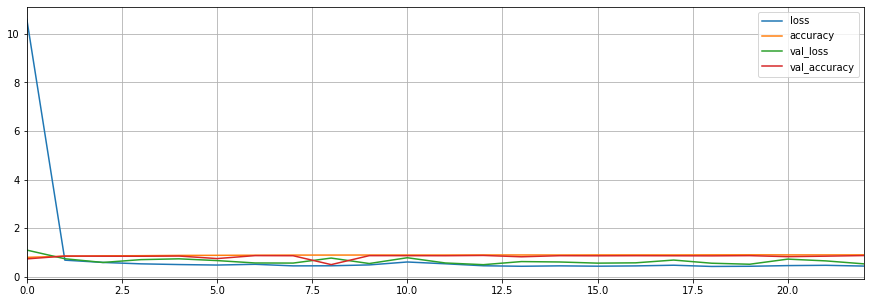

In [90]:
pd.DataFrame(history.history).plot(figsize = (15,5))
plt.grid(True)
plt.show()

In [93]:
%load_ext tensorboard
%tensorboard --logdir=log_dir --port=9009

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
